In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Loading training data...
Loading validation data...
Training SVM classifier...
Evaluating SVM classifier...
Validation Accuracy: 61.67%
              precision    recall  f1-score   support

     Healthy       0.50      0.65      0.57        20
     Powdery       0.81      0.85      0.83        20
        Rust       0.54      0.35      0.42        20

    accuracy                           0.62        60
   macro avg       0.62      0.62      0.61        60
weighted avg       0.62      0.62      0.61        60



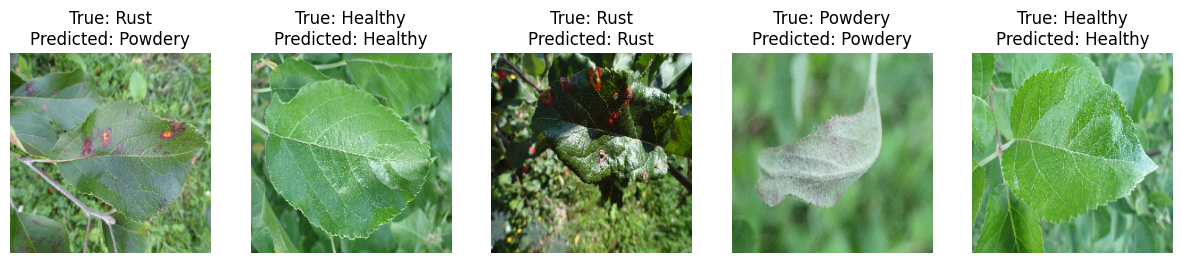

In [4]:
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Function to extract features from images
def extract_features(image_path, target_size=(225, 225)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values
    return image.flatten()  # Flatten to 1D feature vector

# Paths for datasets
train_path = "/content/gdrive/MyDrive/archives/Train/Train"
validation_path = "/content/gdrive/MyDrive/archives/Validation/Validation"

# Load data and labels
def load_data(folder_path):
    data = []
    labels = []
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for img_file in os.listdir(category_path):
                img_path = os.path.join(category_path, img_file)
                try:
                    features = extract_features(img_path)
                    data.append(features)
                    labels.append(category)
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}")
    return np.array(data), np.array(labels)

print("Loading training data...")
X_train, y_train = load_data(train_path)

print("Loading validation data...")
X_val, y_val = load_data(validation_path)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train SVM
print("Training SVM classifier...")
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_scaled, y_train_encoded)

# Evaluate SVM
print("Evaluating SVM classifier...")
y_pred = svm_model.predict(X_val_scaled)
accuracy = accuracy_score(y_val_encoded, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Classification report
print(classification_report(y_val_encoded, y_pred, target_names=label_encoder.classes_))

# Plot sample predictions
import random
import matplotlib.pyplot as plt

random_indices = random.sample(range(len(X_val)), 5)
plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    image = X_val[idx].reshape(225, 225, 3) * 255.0
    plt.imshow(image.astype('uint8'))
    true_label = label_encoder.inverse_transform([y_val_encoded[idx]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred[idx]])[0]
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis('off')
plt.show()


In [10]:
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train_encoded)

print("Evaluating Random Forest classifier...")
y_pred = rf_model.predict(X_val_scaled)
accuracy = accuracy_score(y_val_encoded, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_val_encoded, y_pred, target_names=label_encoder.classes_))


Training Random Forest classifier...
Evaluating Random Forest classifier...
Validation Accuracy: 78.33%
              precision    recall  f1-score   support

     Healthy       0.68      0.75      0.71        20
     Powdery       0.82      0.90      0.86        20
        Rust       0.88      0.70      0.78        20

    accuracy                           0.78        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60



In [11]:
from sklearn.neighbors import KNeighborsClassifier

print("Training K-Nearest Neighbors classifier...")
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_scaled, y_train_encoded)

print("Evaluating K-Nearest Neighbors classifier...")
y_pred = knn_model.predict(X_val_scaled)
accuracy = accuracy_score(y_val_encoded, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_val_encoded, y_pred, target_names=label_encoder.classes_))


Training K-Nearest Neighbors classifier...
Evaluating K-Nearest Neighbors classifier...
Validation Accuracy: 70.00%
              precision    recall  f1-score   support

     Healthy       0.55      0.85      0.67        20
     Powdery       0.94      0.85      0.89        20
        Rust       0.73      0.40      0.52        20

    accuracy                           0.70        60
   macro avg       0.74      0.70      0.69        60
weighted avg       0.74      0.70      0.69        60



In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Load pretrained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(225, 225, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(len(label_encoder.classes_), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Training CNN (MobileNetV2)...")
model.fit(X_train.reshape(-1, 225, 225, 3), y_train_encoded, validation_data=(X_val.reshape(-1, 225, 225, 3), y_val_encoded), epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_val.reshape(-1, 225, 225, 3), y_val_encoded)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


<ipython-input-12-62794487150a>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(225, 225, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training CNN (MobileNetV2)...
Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 462ms/step - accuracy: 0.6874 - loss: 7.7943 - val_accuracy: 0.9333 - val_loss: 0.3447
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9836 - loss: 0.0832 - val_accuracy: 0.9167 - val_loss: 0.8257
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9766 - loss: 0.1634 - val_accuracy: 0.9667 - val_loss: 0.3696
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9922 - loss: 0.0214 - val_accuracy: 0.9667 - val_loss: 0.1430
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9986 - loss: 0.0033 - val_accuracy: 0.9667 - val_loss: 0.1656
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9979 - loss: 0.0022 - val_accuracy: 0.9333 - val_loss: 0.1460
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 1.0000 - loss: 3.0795e-04 - val_accuracy: 0.9667 - val_loss: 0.0800
Epoch 8/10
42/42 ━━━━━━━━━

In [5]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.6 MB/s eta 0:00:00


In [6]:
import pickle

# Save the SVM model
with open("svm_model.pkl", "wb") as model_file:
    pickle.dump(svm_model, model_file)

# Save the label encoder
with open("label_encoder.pkl", "wb") as le_file:
    pickle.dump(label_encoder, le_file)

# Save the scaler
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Model and preprocessing objects saved successfully!")


Model and preprocessing objects saved successfully!


In [7]:
!pip install pyngrok


In [ ]:
pip install gradio

In [18]:
!pip install joblib


In [15]:
model.save("cnn_image_classifier.keras")



In [35]:
import pickle

# Assuming `knn_model` is already trained
with open('knn_model.pkl', 'wb') as knn_file:
    pickle.dump(knn_model, knn_file)

print("KNN model saved successfully!")


KNN model saved successfully!


In [36]:
import pickle

# Assuming `rf_model` is already trained
with open('rf_model.pkl', 'wb') as rf_file:
    pickle.dump(rf_model, rf_file)

print("Random Forest model saved successfully!")


Random Forest model saved successfully!


In [33]:
import gradio as gr
import numpy as np
import os
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image

# Load the trained SVM model and preprocessing objects
with open("svm_model.pkl", "rb") as model_file:
    svm_model = pickle.load(model_file)

with open("label_encoder.pkl", "rb") as le_file:
    label_encoder = pickle.load(le_file)

with open("scaler.pkl", "rb") as scaler_file:
    scaler = pickle.load(scaler_file)

# Load the CNN model
cnn_model = load_model("cnn_image_classifier.keras")  # Replace with your CNN model file path

# Function to extract features from an uploaded image (for SVM)
def extract_features(image_path, target_size=(225, 225)):
    image = Image.open(image_path).resize(target_size)  # Resize the image
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values
    return image.flatten()

# Function to preprocess image for CNN (resize and normalize)
def preprocess_for_cnn(image, target_size=(225, 225)):
    image = image.resize(target_size)  # Resize image for CNN input
    image = img_to_array(image) / 255.0  # Normalize pixel values
    return np.expand_dims(image, axis=0)  # Add batch dimension for CNN

# Function to classify leaf image using both CNN and SVM
def classify_leaf(image):
    # Save the uploaded image temporarily
    temp_image_path = "temp_image.jpg"
    image.save(temp_image_path)

    try:
        # Extract features for SVM and predict
        features = extract_features(temp_image_path)
        features_scaled = scaler.transform([features])
        svm_prediction_proba = svm_model.predict_proba(features_scaled)[0]

        # Prepare SVM outputs
        svm_confidence_scores = {label: float(prob) for label, prob in zip(label_encoder.classes_, svm_prediction_proba)}
        svm_predicted_label = max(svm_confidence_scores, key=svm_confidence_scores.get)

        # Preprocess the image for CNN and predict
        cnn_input = preprocess_for_cnn(image)
        cnn_prediction = cnn_model.predict(cnn_input)
        cnn_predicted_label = label_encoder.inverse_transform([np.argmax(cnn_prediction)])[0]
        cnn_confidence = np.max(cnn_prediction) * 100  # Confidence score for CNN

    finally:
        # Cleanup temporary file
        os.remove(temp_image_path)

    return svm_predicted_label, svm_confidence_scores, cnn_predicted_label, f"{cnn_confidence:.2f}"

# Create the Gradio Interface
interface = gr.Interface(
    fn=classify_leaf,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Textbox(label="SVM Predicted Label"),
        gr.Label(label="SVM Confidence Scores"),
        gr.Textbox(label="CNN Predicted Label"),
        gr.Textbox(label="CNN Confidence (%)"),
    ],
    title="Leaf Disease Classifier",
    description="Upload a leaf image to classify it as Healthy, Powdery, or Rust using both SVM and CNN models.",
)

# Launch the interface
interface.launch()


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5d2e0c3658ef83f0b7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [37]:
import gradio as gr
import numpy as np
import os
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image

# Load the trained models and preprocessing objects
with open("svm_model.pkl", "rb") as model_file:
    svm_model = pickle.load(model_file)

with open("label_encoder.pkl", "rb") as le_file:
    label_encoder = pickle.load(le_file)

with open("scaler.pkl", "rb") as scaler_file:
    scaler = pickle.load(scaler_file)

# Load the CNN model
cnn_model = load_model("cnn_image_classifier.keras")  # Replace with your CNN model file path

# Load the KNN and Random Forest models
with open("knn_model.pkl", "rb") as knn_file:
    knn_model = pickle.load(knn_file)

with open("rf_model.pkl", "rb") as rf_file:
    rf_model = pickle.load(rf_file)

# Function to extract features from an uploaded image (for SVM, KNN, and Random Forest)
def extract_features(image_path, target_size=(225, 225)):
    image = Image.open(image_path).resize(target_size)  # Resize the image
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values
    return image.flatten()

# Function to preprocess image for CNN (resize and normalize)
def preprocess_for_cnn(image, target_size=(225, 225)):
    image = image.resize(target_size)  # Resize image for CNN input
    image = img_to_array(image) / 255.0  # Normalize pixel values
    return np.expand_dims(image, axis=0)  # Add batch dimension for CNN

# Function to classify leaf image using all models
def classify_leaf(image):
    # Save the uploaded image temporarily
    temp_image_path = "temp_image.jpg"
    image.save(temp_image_path)

    try:
        # Extract features for SVM, KNN, and Random Forest and predict
        features = extract_features(temp_image_path)
        features_scaled = scaler.transform([features])

        # SVM Prediction and confidence scores
        svm_prediction_proba = svm_model.predict_proba(features_scaled)[0]
        svm_confidence_scores = {label: float(prob) for label, prob in zip(label_encoder.classes_, svm_prediction_proba)}
        svm_predicted_label = max(svm_confidence_scores, key=svm_confidence_scores.get)

        # KNN Prediction and confidence scores
        knn_prediction = knn_model.predict([features])
        knn_proba = knn_model.predict_proba([features])[0]
        knn_predicted_label = label_encoder.inverse_transform(knn_prediction)[0]
        knn_confidence_scores = {label: float(prob) for label, prob in zip(label_encoder.classes_, knn_proba)}

        # Random Forest Prediction and confidence scores
        rf_prediction = rf_model.predict([features])
        rf_proba = rf_model.predict_proba([features])[0]
        rf_predicted_label = label_encoder.inverse_transform(rf_prediction)[0]
        rf_confidence_scores = {label: float(prob) for label, prob in zip(label_encoder.classes_, rf_proba)}

        # Preprocess the image for CNN and predict
        cnn_input = preprocess_for_cnn(image)
        cnn_prediction = cnn_model.predict(cnn_input)
        cnn_predicted_label = label_encoder.inverse_transform([np.argmax(cnn_prediction)])[0]
        cnn_confidence = np.max(cnn_prediction) * 100  # Confidence score for CNN

    finally:
        # Cleanup temporary file
        os.remove(temp_image_path)

    return (
        svm_predicted_label, svm_confidence_scores,
        knn_predicted_label, knn_confidence_scores,
        rf_predicted_label, rf_confidence_scores,
        cnn_predicted_label, f"{cnn_confidence:.2f}"
    )

# Create the Gradio Interface
interface = gr.Interface(
    fn=classify_leaf,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Textbox(label="SVM Predicted Label"),
        gr.Label(label="SVM Confidence Scores"),
        gr.Textbox(label="KNN Predicted Label"),
        gr.Label(label="KNN Confidence Scores"),
        gr.Textbox(label="Random Forest Predicted Label"),
        gr.Label(label="Random Forest Confidence Scores"),
        gr.Textbox(label="CNN Predicted Label"),
        gr.Textbox(label="CNN Confidence (%)"),
    ],
    title="Leaf Disease Classifier",
    description="Upload a leaf image to classify it using SVM, KNN, Random Forest, and CNN models.",
)

# Launch the interface
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://84be7cfff0e2ed5dba.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
